In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
init_printing(use_latex='mathjax')

In [2]:
C = symbols('c', real=True)
Lam = symbols('\lambda', real=True, positive=True, nonzero=True)
DT = symbols('dt', real=True, positive=True, nonzero=True)



C_star= symbols('c^\star', real=True)  # nieprzesuniete 
C_star

c__\star

In [3]:
Sn = [C]
Ssn = [C_star]

Q = [C*(1+DT/2*Lam)*(1-C**2)]

M = Matrix

In [4]:
EQs = Eq(M(Sn) , DT*M(Q)/2 + M(Ssn))  # originał
# EQs = Eq(M(Sn) , DT*M(Q)/2 - M(Ssn))  
EQs

      ⎡     ⎛     2⎞ ⎛\lambda⋅dt    ⎞           ⎤
      ⎢c⋅dt⋅⎝1 - c ⎠⋅⎜────────── + 1⎟           ⎥
[c] = ⎢              ⎝    2         ⎠           ⎥
      ⎢────────────────────────────── + c__\star⎥
      ⎣              2                          ⎦

In [17]:
tmp2 = list()
tmp = solve(EQs, Sn, dict=True)
for row in tmp:
    tmp2.append(list(row.values()))
        
S_fromSs = Matrix(tmp2)
S_fromSs

⎡                           __________________________________________________
⎢                          ╱                                __________________
⎢                         ╱                                ╱                  
⎢                        ╱                                ╱                   
⎢                       ╱                                ╱      11664⋅c__\star
⎢                      ╱                                ╱    ─────────────────
⎢                     ╱                                ╱                      
⎢                    ╱                                ╱      ⎛          2     
⎢  ⎛  1   √3⋅ⅈ⎞     ╱             54⋅c__\star       ╲╱       ⎝\lambda⋅dt  + 2⋅
⎢  ⎜- ─ - ────⎟⋅   ╱         - ────────────────── + ──────────────────────────
⎢  ⎝  2    2  ⎠ 3 ╱                      2                                    
⎢               ╲╱             \lambda⋅dt  + 2⋅dt                             
⎢- ─────────────────────────────────────────────────

KeyboardInterrupt: 

In [6]:
inputs = [C_star, Lam ,DT]
dummies = symbols("tmp[0:%d]"%len(inputs))

S_fromSs_f_ =  lambdify(dummies, S_fromSs.subs(dict(zip(inputs, dummies))),modules="numpy") 


def S_fromSs_f(*x):
    tmp = S_fromSs_f_(*x)
    for i in range(3):
        if (np.imag(tmp[i]) == 0): return np.real(tmp[i])
    raise Exeption("Something wrong")
    
dummies

(tmp[0], tmp[1], tmp[2])

In [7]:
S_fromSs_f_(2,1,0.5)

array([[-0.73439365+1.95397086j],
       [-0.73439365-1.95397086j],
       [ 1.4687873 +0.j        ]])

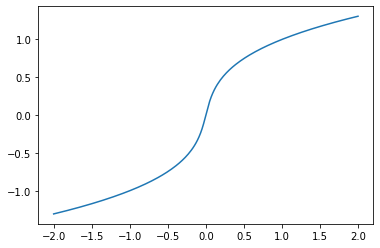

In [8]:
x = np.linspace(-2,2,200)
plt.plot(x, np.vectorize(lambda t_: S_fromSs_f(t_, 1, 1))(x))

In [9]:
def simpler(tt, level = 0):
    if level == 0:
        testme = tt.simplify()
        ops0 = testme.count_ops()
        tested = simpler(testme, 1)
        ops1= tested.count_ops()
        if ops1 < ops0:
            return tested
        else:
            return testme
    else:
        if tt.is_Add:
            coeffs = dict()

            for pp in tt.args:
                for qq in pp.args:
                    if qq in coeffs.keys():
                        coeffs[qq] = coeffs[qq] + 1 
                    else:
                        coeffs[qq] = 1

            if len(coeffs) > 2:
                for pp in np.argsort(coeffs.values())[::-1]:
              #  print tt
                    tt = tt.collect( list(coeffs.keys())[pp] )
            #    print tt
                tmp = list()
                for pp in tt.args:
                    tmp.append(simpler(pp, 1))
                return Add(*tmp)
            else:
                return tt
        elif len(tt.args) > 1:  
            tmp = list()
            for pp in tt.args:
                tmp.append(simpler(pp.expand(), 1))
            return tt.func(*tmp)
        else:
            return tt 

def block_simpler(symbols, exprs, tprefix = 'const real_t '):
    opers0 = 0
    for ee in exprs:
        opers0 = opers0 +  ee.count_ops() + 1
    
    print ("// Opers0 = ", opers0   )
    
    temp = cse(exprs,optimizations='basic')
    opers = 0
    for nn,ee in temp[0]:
        ee = simpler(ee)
        opers = opers +  ee.count_ops() + 1
        print (tprefix, ccode(nn),'=',ccode(ee), '; //', ee.count_ops())

    for nn,ee in zip( symbols, temp[1] ):
        ee = simpler(ee)
        opers = opers + ee.count_ops() + 1
        print (ccode(nn),'=',ccode(ee), '; //', ee.count_ops())

    print ("// Opers = ", opers )
    
for inp, dum in zip(inputs, dummies):
    print("// %s = %s"%(dum, inp))
block_simpler([C], [S_fromSs.subs(dict(zip(inputs, dummies)))[2]])

// tmp[0] = c^\star
// tmp[1] = \lambda
// tmp[2] = dt
// Opers0 =  82
const real_t  x0 = cbrt(3) ; // 2
const real_t  x1 = tmp[1]*tmp[2] + 2 ; // 2
const real_t  x2 = 1/(tmp[2]*x1) ; // 2
const real_t  x3 = pow(tmp[2], 2) ; // 1
const real_t  x4 = 2*tmp[2] ; // 1
const real_t  x5 = tmp[1]*x3 ; // 1
const real_t  x6 = cbrt(-18*tmp[0]*x2 + sqrt(3)*sqrt((108*pow(tmp[0], 2) + x2*pow(-x4 - x5 + 4, 3))/(pow(x1, 2)*x3))) ; // 20
c = -1.0/3.0*x0*(x0*x2*(x4 + x5 - 4) + pow(x6, 2))/x6 ; // 10
// Opers =  47
